# SpineNet Lumbar Grading Example

Last edited: 05/07/2022

This notebook shows an example of using SpineNet to grade a typical T2 lumbar scan
on CUDA-enabled hardware. Note that it is also possible to run SpineNet on a CPU
only (however, this will be slower).


## 01. Loading In SpineNet + Data

In [1]:
import sys
import os
from pathlib import Path
sys.path.insert(0, str(Path(os.getcwd()).parent)) # Add parent directory to path. This shouldn't be needed if SpineNet is pip-installed



import spinenet
from spinenet import SpineNet, download_example_scan
from spinenet.io import load_dicom_from_folder

# download example scans 
os.makedirs('example_scans', exist_ok=True)

# download_example_scan('t2_lumbar_scan_1', file_path='example_scans')
# or use the other example scan available
example_scan_folder = 'example_scans/t2_lumbar_scan_2/'
download_example_scan('t2_lumbar_scan_2', file_path='example_scans')


# download weights from server. This may take a minute or two.
# You do not need to run this line if weights have already been downloaded.
spinenet.download_weights(verbose=True, force=False)

# load in spinenet. Replace device with 'cpu' if you are not using a CUDA-enabled machine.
spnt = SpineNet(device='cuda:0', verbose=True)




# metadata to be overwritten in the scan - useful if certain important values are missing from some/all dicom files
# in this case, slice thickness and image orientation are missing from the dicom files and so we add false values
# of 2mm and a sagittal orientation code ([0,1,0,0,0,1]). 
# Do not overwrite this metadata if it already exists in the dicom files being used.
overwrite_dict = {'SliceThickness': [2], 'ImageOrientationPatient': [0, 1, 0, 0, 0, -1]}


# loads in a dicom from the example scan folder.
# if set, the `require_extensions` flag requires that files end with `.dcm`
scan = load_dicom_from_folder(example_scan_folder, require_extensions=False, metadata_overwrites=overwrite_dict)


example_scans/temp_file.zip: 100%|██████████| 2.47M/2.47M [00:00<00:00, 80.1MiB/s]


/users/rhydian/spinenet-v2-opensource/spinenet/io/download.py:64: UserWarning: /users/rhydian/spinenet-v2-opensource/spinenet/weights/grading/ckpt1.pt already exists. Skipping download.
  warnings.warn('{} already exists. Skipping download.'.format(fname))
/users/rhydian/anaconda3/envs/default_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/users/rhydian/anaconda3/envs/default_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading Detection Model...
==> Loading model trained for 436 epochs...
Loading Appearance Model...
==> Loading model trained for 188 epochs...
Loading Context Model...
==> Loading model trained for 17 epochs...
Loading Grading Model...
==> Loading model trained for 2 epochs...


## 02. Visualize Scan Slices

Show each slice from the sagittal T2 lumbar scan and print out metadata information.

Scan has 12 sagittal slices, of dimension 512x512 (0.5 mm pixel spacing) and 2.0 mm slice thickness.


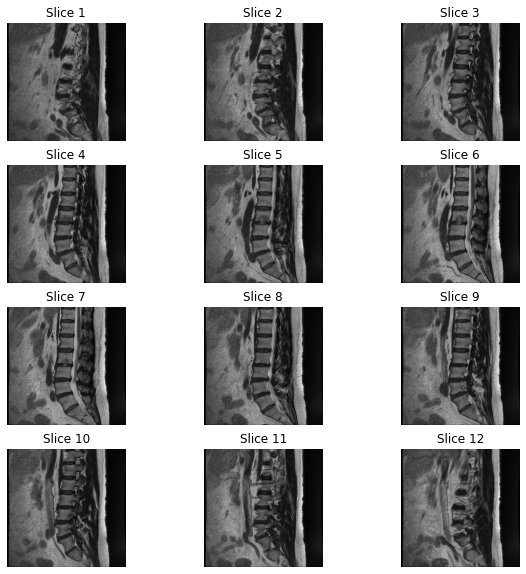

In [2]:
print(f'Scan has {scan.volume.shape[-1]} sagittal slices, of dimension {scan.volume.shape[0]}x{scan.volume.shape[1]} ({scan.pixel_spacing} mm pixel spacing) and {scan.slice_thickness} mm slice thickness.')


import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))

# show each sagittal slice
for slice_idx in range(scan.volume.shape[-1]):
    ax = fig.add_subplot(4,3,slice_idx+1)
    ax.imshow(scan.volume[:,:,slice_idx], cmap='gray')
    ax.set_title(f'Slice {slice_idx+1}')
    ax.axis('off')


## 03. Detect Vertebrae
Use SpineNet to detect vertebrae and then show the detections in slices.

8 vertebrae detected; ['T11', 'T12', 'L1', 'L2', 'L3', 'L4', 'L5', 'L5']


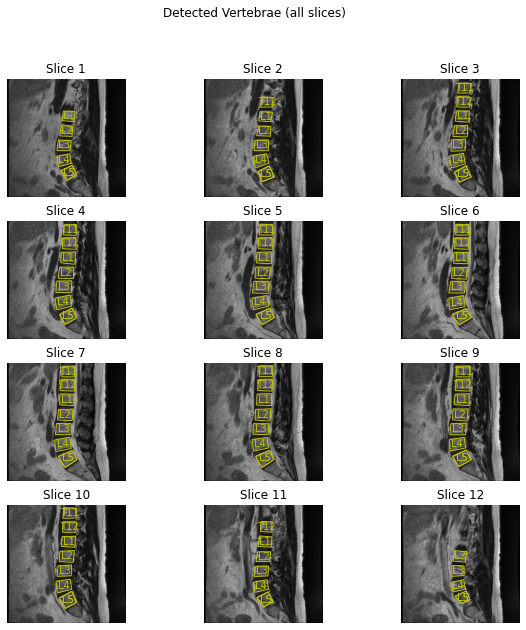

In [3]:
# detect and identify vertebrae in scan. Note that pixel spacing information is required 
# so SpineNet knows what size to split patches into.
vert_dicts = spnt.detect_vb(scan.volume, scan.pixel_spacing)

print(f'{len(vert_dicts)} vertebrae detected; {[vert_dict["predicted_label"] for vert_dict in vert_dicts]}')


# visualize vertebrae detections in slices 
from matplotlib.patches import Polygon 
import numpy as np
fig = plt.figure(figsize=(10,10))
for slice_idx in range(scan.volume.shape[-1]):
    ax = fig.add_subplot(4,3,slice_idx+1)
    ax.imshow(scan.volume[:,:,slice_idx], cmap='gray')
    ax.set_title(f'Slice {slice_idx+1}')
    ax.axis('off')
    for vert_dict in vert_dicts:
        if slice_idx in vert_dict['slice_nos']:
            poly_idx = int(vert_dict['slice_nos'].index(slice_idx))
            poly = np.array(vert_dict['polys'][poly_idx])
            ax.add_patch(Polygon(poly, ec='y',fc='none'))
            ax.text(np.mean(poly[:,0]), np.mean(poly[:,1]), vert_dict['predicted_label'],c='y', ha='center',va='center')

fig.suptitle('Detected Vertebrae (all slices)')
plt.show()

## 04. Show vertebrae detections in the mid sagittal slice

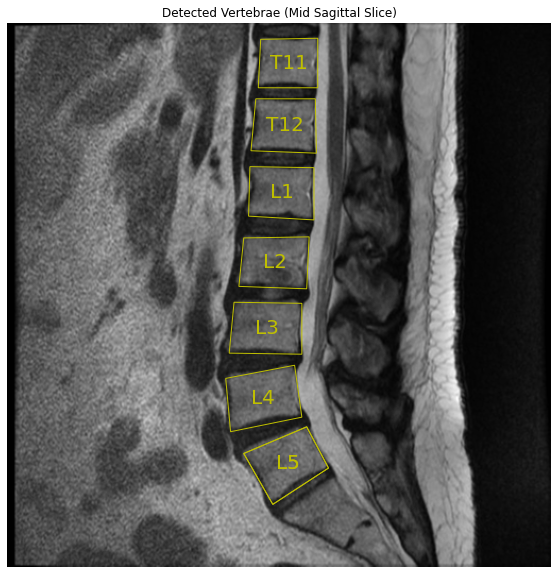

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
# plot mid sagittal slice and detected vertebrae
plt.figure(figsize=(10,10))
plt.imshow(scan.volume[:,:,scan.volume.shape[-1]//2], cmap='gray')
for idx, vert_dict in enumerate(vert_dicts):
    if scan.volume.shape[-1]//2 in vert_dict['slice_nos']:
        poly = np.array(vert_dict['polys'][vert_dict['slice_nos'].index(scan.volume.shape[-1]//2)])
        plt.gca().add_patch(Polygon(poly, fc='none', ec='y'))
        plt.text(np.mean(poly[:,0]), np.mean(poly[:,1]), vert_dict['predicted_label'], color='y',fontsize=20, va='center', ha='center')
    else:
        continue

plt.axis('off')
plt.title('Detected Vertebrae (Mid Sagittal Slice)')
plt.show()


## 05. Perform grading of T2 scans for common radiological conditions

Since this is a T2 sagittal lumbar scan, SpineNet can be used to perform radiological grading for several common spinal degenerative conditions. Note that this is trained on IVDs from T12/L5 to L5/S1 so may not be accurate for vertebrae outside this range.

In [5]:
# extract IVDs using the detections from the previous stage.
ivd_dicts = spnt.get_ivds_from_vert_dicts(vert_dicts, scan.volume)

# grade IVDs - note that this is only validated on IVDs from L5/S1 to T12/L5 vertebrae.
# IVDs gradings are output as a pandas dictionary. For information on the grading schemes used, see http://zeus.robots.ox.ac.uk/spinenet2/
ivd_grades = spnt.grade_ivds(ivd_dicts)
ivd_grades.head(len(ivd_dicts))

,Pfirrmann,Narrowing,CentralCanalStenosis,Spondylolisthesis,UpperEndplateDefect,LowerEndplateDefect,UpperMarrow,LowerMarrow,ForaminalStenosisLeft,ForaminalStenosisRight,Herniation
T11-T12,1,1,1,0,0,0,0,0,0,0,0
T12-L1,2,1,1,0,0,0,0,0,0,0,0
L1-L2,3,1,1,0,0,0,0,0,0,0,0
L2-L3,3,2,1,0,0,0,0,0,0,0,0
L3-L4,3,2,1,0,0,0,0,0,0,0,0
L4-L5,3,2,1,0,0,0,0,0,0,0,0
L5-L5,3,3,1,0,0,0,0,0,0,0,0
